In [1]:
import sys

sys.path.append("..")
sys.path.append("../../")
sys.path.append("../../src")

import os
import numpy as np
import matplotlib.pyplot as plt
from functional_autoencoders.util import pickle_load
from plots import set_plot_style_publication, get_cmap

In [2]:
def plot_wallclock(ax, losses, right_lim=100):
    cs = get_cmap("Reds", len(losses))
    linestyles = ["-", "--", ":"]
    shapes = ["o", "s", "^"]
    for i, ratio in enumerate(losses.keys()):
        xs = losses[ratio].keys()
        ys = [losses[ratio][x] for x in xs]
        ax.plot(xs, ys, ls=linestyles[i], label=f"{(ratio * 100):.0f}\\%", color=cs[i])
        ax.scatter(xs, ys, marker=shapes[i], color=cs[i])
    ax.set_xlim(left=0, right=right_lim)
    ax.set_ymargin(0.08)
    ax.xaxis.set_tick_params(top=False, which="both")
    ax.yaxis.set_tick_params(right=False, which="both")
    ax.legend(title="Point \\%\n(training)")


def update_mse_test_losses_per_ratio(data_output_dir):
    mse_over_runs = {}
    training_times_over_runs = {}
    mse_test_losses_per_ratio = {}
    for run_idx_str in os.listdir(data_output_dir):
        for train_point_ratio in os.listdir(os.path.join(data_output_dir, run_idx_str)):
            result = pickle_load(
                os.path.join(
                    data_output_dir, run_idx_str, train_point_ratio, "data.pickle"
                )
            )

            mse = result["training_results"]["metrics_history"]["MSE (in L^{2})"]
            training_time = result["additional_data"]["training_time"]
            train_point_ratio = result["additional_data"]["train_point_ratio"]

            if train_point_ratio not in mse_over_runs:
                mse_over_runs[train_point_ratio] = []
                training_times_over_runs[train_point_ratio] = []

            mse_over_runs[train_point_ratio].append(mse)
            training_times_over_runs[train_point_ratio].append(training_time)

    for train_point_ratio in mse_over_runs.keys():
        mse = np.array(mse_over_runs[train_point_ratio])
        training_times = np.array(training_times_over_runs[train_point_ratio])

        mse_values_mean = np.mean(mse, axis=0)
        training_times_mean = np.mean(training_times, axis=0)
        t_range = np.linspace(0, training_times_mean, len(mse_values_mean))

        mse_test_losses_per_ratio[train_point_ratio] = {
            t: mse for t, mse in zip(t_range, mse_values_mean)
        }

    return mse_test_losses_per_ratio

In [3]:
data_output_dir = f"../../tmp/experiments/exp_sparse_vs_dense_wall_clock_training/data/"
mse_test_losses_per_ratio = update_mse_test_losses_per_ratio(data_output_dir)

In [4]:
for ratio in mse_test_losses_per_ratio.keys():
    losses = mse_test_losses_per_ratio[ratio]

    # Get min loss and corresponding time
    min_time, min_loss = min(
        sorted(list(losses.items()), key=lambda x: x[0]),
        key=lambda x: x[1],
    )
    for t in list(losses.keys()):
        if t > min_time:
            del losses[t]

mse_test_losses_per_ratio = dict(sorted(mse_test_losses_per_ratio.items()))

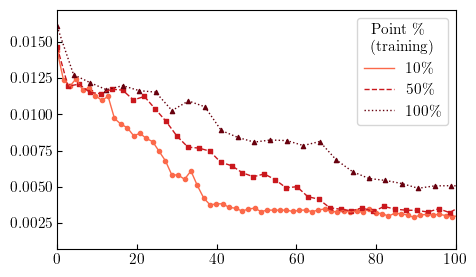

In [5]:
SAVE_DIR = None
# SAVE_DIR = '../../figures/sparse_vs_dense_wall_clock_training'
# os.makedirs(SAVE_DIR, exist_ok=True)

set_plot_style_publication()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4.9, 2.9)
plot_wallclock(ax, mse_test_losses_per_ratio, right_lim=100)

if SAVE_DIR is not None:
    plt.savefig(f"{SAVE_DIR}/darcy_wallclock.pdf")
    plt.close()
else:
    plt.tight_layout()
    plt.show()